In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q3: Efficient Tracking

Make sure to comment your code and use proper names for your variables.

## Q3.1: Lucas-Kanade with Inverse Composition

In [2]:
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import affine_transform
# import cv2

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    
    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    # TODO: Add your Efficient LK implementation here: 
    M = np.vstack([M, [0, 0, 1]])
    
    Itfn = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1fn = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    x1, y1, x2, y2 = 0, 0, It.shape[0] - 1, It.shape[1] - 1
    x = np.arange(x1 ,x2 + 1)
    y = np.arange(y1, y2 + 1)
    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    template = Itfn.ev(X, Y)
    
    Tx = Itfn.ev(X, Y, dx=1, dy=0)[:, np.newaxis]
    Ty = Itfn.ev(X, Y, dx=0, dy=1)[:, np.newaxis]

    Xt = X[:, np.newaxis]
    Yt = Y[:, np.newaxis]
    Aprime = np.hstack([Tx * Xt, Tx * Yt, Tx, Ty * Xt, Ty * Yt, Ty])
    def threshcheck(pval):
        return np.linalg.norm(pval, ord=2)**2 < threshold
    
    p = M.flatten()
    dp = [0] * len(p)
    
    for i in range(num_iters):
        # warp
        xhat = p[0] * X + p[1] * Y + p[2]
        yhat = p[3] * X + p[4] * Y + p[5]
        
        # mask
        valid_locations = np.where((xhat >= x1) & (xhat <= x2) & (yhat >= y1) & (yhat <= y2), True, False)
        xhat = xhat[valid_locations]
        yhat = yhat[valid_locations]

        # b prime
        bprime = It1fn.ev(xhat, yhat) - template[valid_locations]
        bprime = bprime[:, np.newaxis]
        
        # compositional update
        Aprime_masked = Aprime[valid_locations, :]
        dp = np.linalg.lstsq(Aprime_masked, bprime, rcond=None)[0].squeeze(axis=1)
        # need save dp, before adding 1s for M to check threshold
        dpp = np.copy(dp)
        dp[0] += 1
        dp[4] += 1
        dm = np.vstack([dp.reshape((2, 3)), np.array([0, 0, 1])])
        M = M @ np.linalg.inv(dm)
        p = M[:2, :].flatten()
        if threshcheck(dpp):
            break
    return M

## Q3.1 Subtract Dominant Motion

Re-use your implementation for Q2.2. 

Just make sure to use InverseCompositionAffine within. 

In [3]:
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
# import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    # mask = np.ones(It1.shape, dtype=bool)
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    It_warped = affine_transform(It, np.linalg.inv(M), output_shape=It.shape)
    diff = np.abs(It_warped - It1)
    moving_objects_mask = np.where(diff > tolerance, 1, 0)
    structuring_element = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ])
    moving_objects_mask = binary_dilation(moving_objects_mask, structuring_element, iterations=3)
    moving_objects_mask = binary_erosion(moving_objects_mask, structuring_element)
    return moving_objects_mask

## Q3.2: Track Sequence

Re-use your implementation for Q2.3

In [4]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:, :, 0]

    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i - 1]
        It1 = seq[:, :, i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    masks = np.stack(masks, axis=2)
    return masks

### Q3.2: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [5]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks_inverse.npy', masks)

100%|██████████| 124/124 [00:14<00:00,  8.63it/s]


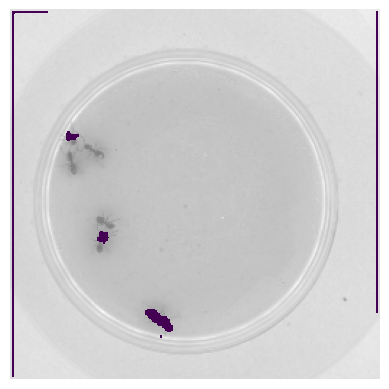

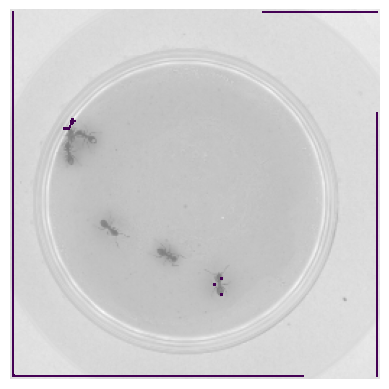

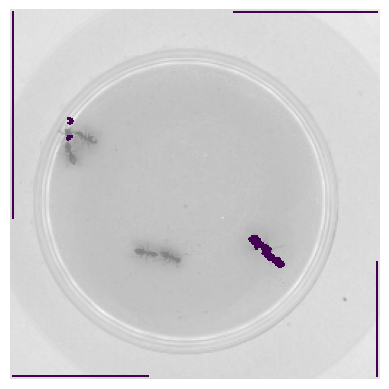

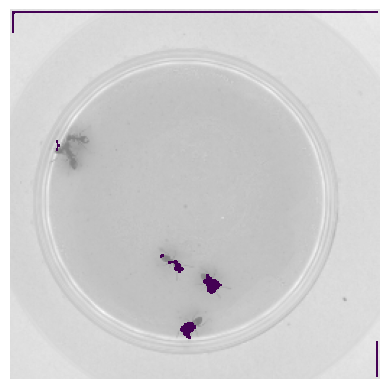

In [6]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_antseq_{idx+1}.png")

### Q3.2: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [7]:
seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks_inverse.npy', masks)

100%|██████████| 149/149 [00:43<00:00,  3.45it/s]


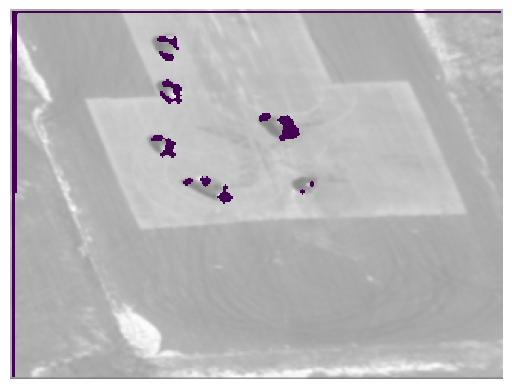

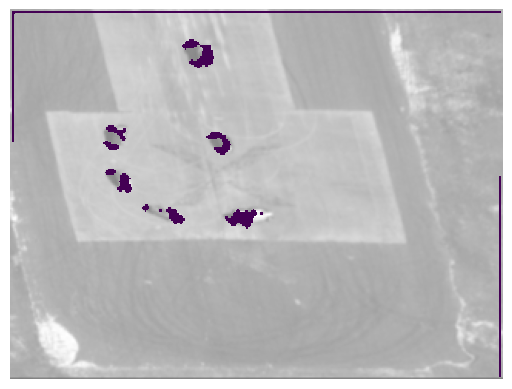

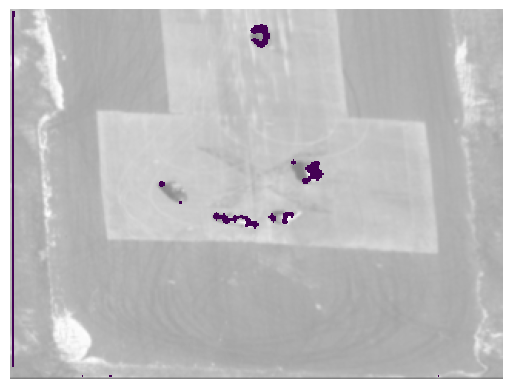

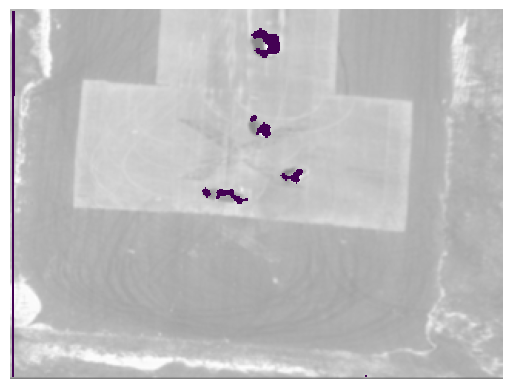

In [8]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_aerialseq_{idx+1}.png")